### Kaggle Link
https://www.kaggle.com/c/porto-seguro-safe-driver-prediction

### Data Description

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., *ind*, *reg*, *car*, *calc*). In addition, feature names include the postfix **bin** to indicate binary features and **cat** to indicate categorical features. Features without these designations are either continuous or ordinal. Values of *-1* indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings

sns.set(style='white')
%matplotlib inline

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df_train = pd.read_csv('../Data/Kaggle/PortoSeguro/train.csv')
df_test  = pd.read_csv('../Data/Kaggle/PortoSeguro/test.csv')

In [ ]:
df_ids = df_test['id']
for df in [df_train, df_test]:
    df.drop(['id'], axis=1, inplace=True)

In [ ]:
df_train = df_train.replace(-1, np.NaN)

In [ ]:
len(df_train)

In [ ]:
df_train.head()

### Exploratory Analysis

In [ ]:
missing_columns = df_train.columns[df_train.isnull().any()].tolist()

In [ ]:
msno.matrix(df_train[missing_columns])

In [ ]:
df_train.fillna(-1, inplace=True)

In [ ]:
binary_feat = [c for c in df_train.columns if c.endswith('bin')]
categorical_feat = [c for c in df_train.columns if c.endswith('cat')]
other_feat = df_train.columns.difference(binary_feat + categorical_feat).values

In [ ]:
plt.figure(figsize=(20, 20))
for i, c in enumerate(binary_feat):
    if df_train[c].nunique() < 10:
        ax = plt.subplot(6, 3, i+1)
        sns.countplot(df_train[c])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
plt.tight_layout()

In [ ]:
plt.figure(figsize=(20, 20))
i = 0
for c in categorical_feat:
    if df_train[c].nunique() < 10:
        ax = plt.subplot(5, 3, i+1)
        sns.countplot(df_train[c])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        i += 1
plt.tight_layout()

In [ ]:
plt.figure(figsize=(20, 20))
i = 0
for c in categorical_feat:
    if df_train[c].nunique() > 10:
        ax = plt.subplot(6, 3, i+1)
        sns.countplot(df_train[c])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        i += 1
plt.tight_layout()

In [ ]:
corr = df_train[other_feat].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
corr = df_train[binary_feat+categorical_feat+['target']].corr(method='spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
X_train = df_train.drop(['target'], axis=1)
y_train = df_train['target']
X_valid = df_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [ ]:
def ginic(actual, pred):
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_c[-1] - (n + 1) / 2.0
    return giniSum / n
 
def gini_normalizedc(a, p):
    if p.ndim == 2:  # Required for sklearn wrapper
        p = p[:,1]   # If proba array contains proba for both 0 and 1 classes, just pick class 1
    return ginic(a, p) / ginic(a, a)

#XGBoost
from sklearn import metrics
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalizedc(labels, preds)
    return [('gini', gini_score)]

#SKlearn
gini_sklearn = metrics.make_scorer(gini_normalizedc, True, True)

#### Random Forest

In [ ]:
def plot_importances(clf, features):
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(15, 5))
    plt.title("Feature importances")
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), features[indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier()
clf_rf_params = {
    'n_estimators': [100, 200, 300, 400]
}

grid = GridSearchCV(clf_rf, clf_rf_params, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

print (grid.best_params_)

In [ ]:
clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf_rf.fit(X_train, y_train)

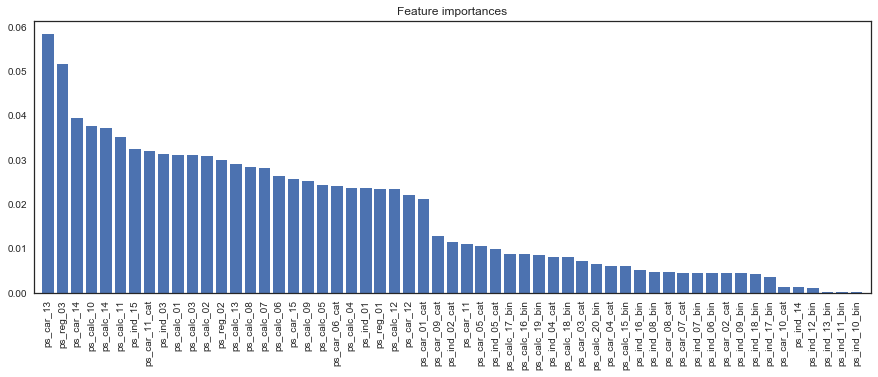

In [25]:
plot_importances(clf_rf, X_train.columns.values)

In [27]:
scores = cross_val_score(clf_rf, X_test, y_test, scoring='accuracy', cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.96 (+/- 0.00)


In [28]:
y_pred = clf_rf.predict_proba(X_valid)

In [32]:
submission = pd.DataFrame({'id': df_ids, 'target': y_pred[:, 1]})
submission.to_csv('clf_rf-output.csv', index=False)

#### XGBoost

In [33]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
import xgboost as xgb

In [ ]:
clf_xgb = xgb.XGBRegressor(silent=1, objective='binary:logistic')
clf_xgb_params = {
    'n_estimators':       [50, 100, 200, 300],
    'learning_rate':      [0.05, 0.1, 0.5],
    'max_depth':          [2, 3, 5, 10],
    'min_child_weight':   [1, 3, 5, 7],
    'subsample':          [0.3, 0.5, 0.8, 1.0],
    'colsample_bytree':   [0.3, 0.5, 0.7, 1.0],
    'colsample_bylevel':  [0.5, 0.7, 1.0]
}

grid = GridSearchCV(clf_xgb, clf_xgb_params, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

print (grid.best_params_)

Fitting 5 folds for each of 9216 candidates, totalling 46080 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min


In [ ]:
clf_xgb = xgb.XGBRegressor(silent=1, colsample_bylevel=0.7, colsample_bytree=0.3, learning_rate=0.05, 
                           max_depth=2, min_child_weight=1, n_estimators=300, subsample=0.5).fit(X_train, y_train)

In [ ]:
y_pred = clf_xgb.predict(X_valid)

In [ ]:
submission = pd.DataFrame({'PassengerId': df_ids, 'Survived': y_pred})
submission.to_csv('titanic-output.csv', index=False)